# Homework Week 2

Second week of December.  Left this too late and did not finish the homework until after the lecture.  But this is important because it gets to results and confidence intervals.  I might have to do this in R to really sort out.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)  #suppress Arviz warnings

# Question 1
## Get data


In [2]:
d = pd.read_csv("../resources/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Filter out children

As before, we should take out children

In [3]:
d_adult = d[d["age"] >= 18]

## Create QUAP regression model

In [4]:
weight_avg = d_adult["weight"].mean()

In [5]:
with pm.Model() as mod1:
    sigma = pm.Uniform("sigma", 0, 50)
    alpha = pm.Normal("alpha", 178, 20)
    beta = pm.Lognormal("beta", 0 , 1)
    mu = alpha + beta * (d_adult["weight"] - weight_avg)
    height = pm.Normal("height", mu, sigma, observed = d_adult["height"])

In [6]:
map_estimate = pm.find_MAP(model=mod1)
map_estimate

{'sigma_interval__': array(-2.18135226),
 'alpha': array(154.60136748),
 'beta_log__': array(-0.10172172),
 'sigma': array(5.07188029),
 'beta': array(0.90328088)}

## PyMC3 approach

PyMC3 guys really don't like quadratic approximation, so they run a MCMC sample:

In [7]:
with mod1:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [8]:
trace

<MultiTrace: 2 chains, 1000 iterations, 5 variables>

In [9]:
tracedf = pm.trace_to_dataframe(trace)
tracedf

,alpha,sigma,beta
0,155.381839,5.401743,1.003218
1,154.170484,4.974143,0.826862
2,154.265369,5.013381,0.871626
3,154.509934,4.946468,0.878861
4,154.640485,4.880572,0.921398
...,...,...,...
1995,154.477841,5.476914,0.882949
1996,154.607109,4.732440,0.904901
1997,154.536713,5.416233,0.917506
1998,154.400738,4.964876,0.869427


In [10]:
with mod1:
    mod1sum = az.summary(trace, round_to=2, kind="stats")
mod1sum

,mean,sd,hdi_3%,hdi_97%
alpha,154.59,0.27,154.11,155.12
sigma,5.10,0.19,4.77,5.46
beta,0.90,0.04,0.82,0.98


In [11]:
new = pd.DataFrame({"weight": [45, 40, 65, 31]})

In [12]:
new.head()

,weight
0,45
1,40
2,65
3,31


The parameters in the summary table are indexes.  Have to use `loc`.

In [13]:
new["exp_height"] = mod1sum.loc["alpha"]["mean"] + mod1sum.loc["beta"]["mean"] * (new["weight"] - weight_avg)
new

,weight,exp_height
0,45,154.598563
1,40,150.098563
2,65,172.598563
3,31,141.998563


## Conclusions during session

Confidence interval is a bit harder.  I think I need to use the samples to generate all this.

Richard uses extract.samples in R.  He will post solutions to some place (Git hub page).
* why does this give 10,000 values in R?
* mu is expected mean; use sigma to get random error
* can use Richard's approach to simulate Fortis job cost and compare!

### Simulate final height

Final height is the observable value (response variable which is the result of everything else in the linear model).  We can recreate the formula for height by including mu, sigma, and the normal distribution.

In [14]:
mu_45 = trace["alpha"] + trace["beta"] * (45 - weight_avg)

In [15]:
mu_45.shape

(2000,)

In [16]:
h_45 = stats.norm.rvs(mu_45, trace["sigma"])

In [17]:
np.quantile(h_45, 0.055)

146.23544898175098

Why can't I get the 5.5% interval to be 146.5?

__Answer:__ Because `percentile` uses values between 0-100 and `quantile` between 0-1.0.

In [18]:
len(h_45)

2000

In [19]:
sum(h_45 <= 146.5)/len(h_45)

0.059

# Redo for data frame

Starting over. Steps:
1. create an empty dataframe of for out-of-sample data
2. estimate the mean using the trace
3. write in the CIs using the trace

Start over by recreating the new dataframe:

## Why this is wrong

It is not necessarily wrong, I don't think.  The problem is the sample size&mdash;it is too small.  We can use the `sample_posterior_predictive` function instead.

No, sample size is not the issue.  Still use `sample_posterior_predictive` because it generates estimates of the response variable (height for every row or predictor variables.  So, if I have an observation with weight = 55, I get 4,000 estimates of height for that weight (varying the parameters of the linear equation on each of the 4000 iterations)

In [20]:
with mod1:
    ppc = pm.sample_posterior_predictive(trace, var_names=["height", "alpha", "beta", "sigma"])

In [21]:
ppc["height"].shape

(2000, 352)

C:\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


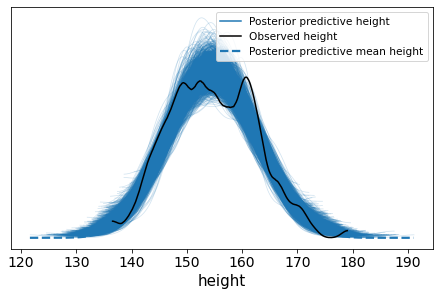

In [22]:
with mod1:
    idata = az.from_pymc3(trace, posterior_predictive=ppc)
az.plot_ppc(idata);

In [23]:
with pm.Model() as mod2:
    sigma = pm.Uniform("sigma", 0, 50)
    alpha = pm.Normal("alpha", 178, 20)
    beta = pm.Lognormal("beta", 0 , 1)
    weight = pm.Data("weight", d_adult["weight"])
    mu = alpha + beta * (weight - weight_avg)
    height = pm.Normal("height", mu, sigma, observed = d_adult["height"])

In [24]:
with mod2:
    trace2 = pm.sample(4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 15 seconds.


In [25]:
new_weight = {"weight": new["weight"].values}
new_weight

{'weight': array([45, 40, 65, 31], dtype=int64)}

In [26]:
with mod2:
    pm.set_data(new_weight)
    preds = pm.sample_posterior_predictive(trace2)

In [27]:
preds["height"].shape

(8000, 4)

In [28]:
preds["height"].mean(0)

array([154.46793285, 150.16455567, 172.66992646, 141.98424176])

In [29]:
preds["height"].mean(0)

array([154.46793285, 150.16455567, 172.66992646, 141.98424176])

In [30]:
np.mean(preds["height"], 0)

array([154.46793285, 150.16455567, 172.66992646, 141.98424176])

In [31]:
np.percentile(preds["height"], 0.055, axis=0)

array([137.08558506, 133.15005352, 155.45722328, 126.04015523])

In [32]:
np.percentile(preds["height"], 0.945, axis=0)

array([142.71619897, 138.36771115, 160.74395858, 130.13640384])

# Question 2


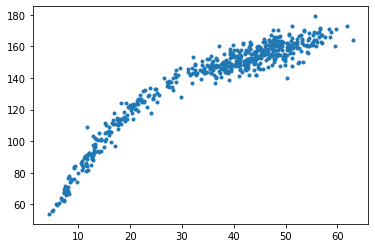

In [33]:
plt.plot(d.weight, d.height, ".");

In [34]:
# precompute log of predictor
d["weight_l"] = np.log(d["weight"])
weight_lavg = d["weight_l"].mean()

In [35]:
with pm.Model() as logm1:  # logged model (predictor)
    a = pm.Normal("a", 178, 20)
    b = pm.Lognormal("b", 0, 1) # expect a positive slope: heavier people should not be shorter (?)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", a + b * (d["weight_l"] - weight_lavg)) # include mu in trace
    height = pm.Normal("height", mu, sigma, observed=d["height"])
    
    trace_l1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [36]:
with logm1:
    logm_sum = az.summary(trace_l1, round_to=2, kind="stats", var_names=["~mu"])
logm_sum

,mean,sd,hdi_3%,hdi_97%
a,138.27,0.23,137.85,138.74
b,47.07,0.39,46.35,47.80
sigma,5.16,0.16,4.88,5.46


## Plot predictions against raw data

In [37]:
trace_l1["mu"].shape

(2000, 544)

In [38]:
len(trace_l1["mu"].mean(0))

544

Need a weight sequence for the mu line if I want to use a solid line.

Double check notation and axis for mean parameters from trace:

In [39]:
trace_l1["a"].mean(0)

138.26911739513793

In [40]:
weight_lseq = d["weight_l"].sort_values()
mu_seq = trace_l1["a"].mean(0) + trace_l1["b"].mean(0) * (weight_lseq - weight_lavg)

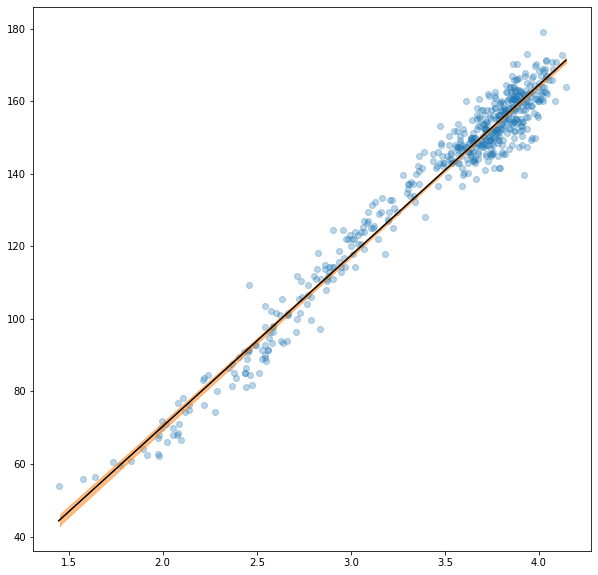

In [41]:
__, ax = plt.subplots(figsize=(10,10))
plt.scatter(d.weight_l, d.height, alpha=0.3) #data (logged predictor)
plt.plot(weight_lseq, mu_seq, "k-") # mean line
az.plot_hdi(d.weight_l, trace_l1["mu"], ax=ax)

plt.show()

## Posterior predictive

To plot predicted heights, need a posterior predictive dataset:

In [42]:
with logm1:
    h_pred = pm.sample_posterior_predictive(trace_l1)

In [43]:
h_pred["height"].shape

(2000, 544)

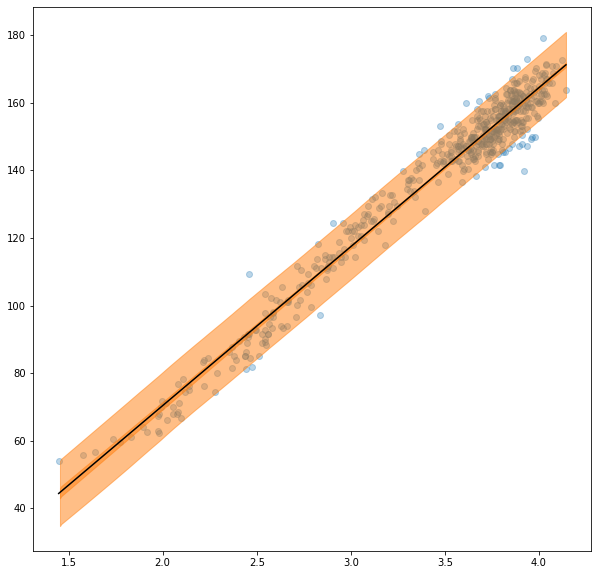

In [44]:
__, ax = plt.subplots(figsize=(10,10))
plt.scatter(d.weight_l, d.height, alpha=0.3) #data (logged predictor)
plt.plot(weight_lseq, mu_seq, "k-") # mean line
az.plot_hdi(d.weight_l, trace_l1["mu"], ax=ax)
az.plot_hdi(d.weight_l, h_pred["height"], ax=ax)
plt.show()

## Plotting on natural axis

Richard's solution shows plots on natural axis.  I think this means just changing the series in the data frame.

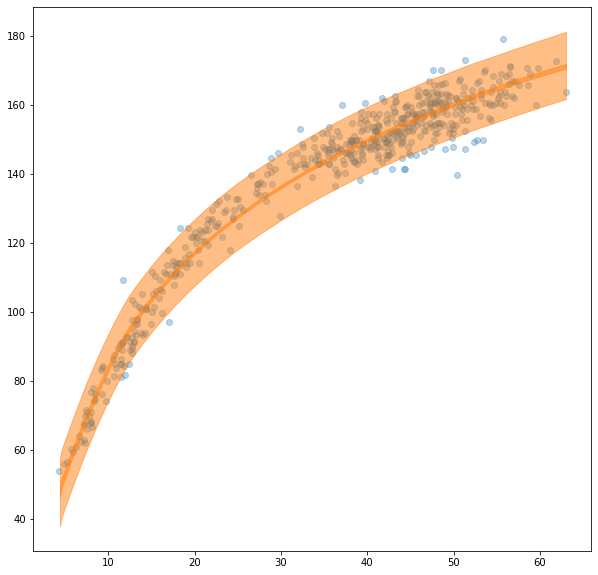

In [45]:
__, ax = plt.subplots(figsize=(10,10))
plt.scatter(d.weight, d.height, alpha=0.3) #data (logged predictor)
#plt.plot(weight_lseq, mu_seq, "k-") # mean line
az.plot_hdi(d.weight, trace_l1["mu"], ax=ax)
az.plot_hdi(d.weight, h_pred["height"], ax=ax)
plt.show()

Now, I have to change the sequence (for the mean line) to natural units:

In [46]:
weight_seq = d["weight"].sort_values()
mu_seq = trace_l1["a"].mean(0) + trace_l1["b"].mean(0) * (np.log(weight_seq) - weight_lavg)

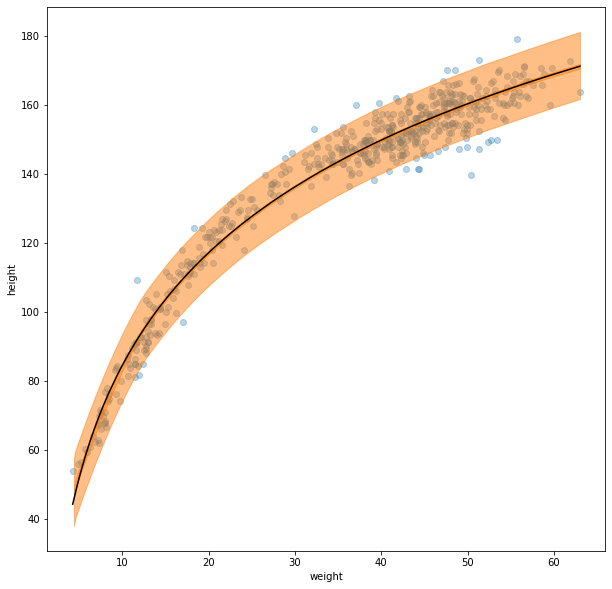

In [47]:
__, ax = plt.subplots(figsize=(10,10))
plt.scatter(d.weight, d.height, alpha=0.3) #data (logged predictor)
plt.plot(weight_seq, mu_seq, "k-") # mean line
az.plot_hdi(d.weight, trace_l1["mu"], ax=ax)
az.plot_hdi(d.weight, h_pred["height"], ax=ax)

ax.set(xlabel="weight", ylabel="height")
plt.show()

# Question 3

Prior predictive for polynomial model in Chapter 4.

Start by precomputing standardized and squared variables:


In [48]:
d

,height,weight,age,male,weight_l
0,151.765,47.825606,63.0,1,3.867561
1,139.700,36.485807,63.0,0,3.596923
2,136.525,31.864838,65.0,0,3.461503
3,156.845,53.041915,41.0,1,3.971082
4,145.415,41.276872,51.0,0,3.720302
...,...,...,...,...,...
539,145.415,31.127751,17.0,1,3.438100
540,162.560,52.163080,31.0,1,3.954375
541,156.210,54.062496,21.0,0,3.990141
542,71.120,8.051258,0.0,1,2.085828


In [49]:
weight_avg = d["weight"].mean()   # for all rows, not just adults here
d["weight_s"] = (d["weight"] - weight_avg)/d["weight"].std()
d["weight_s2"] = d["weight_s"] ** 2

In [97]:
with pm.Model() as poly:  # polynomial regression from 4.65
    a = pm.Normal("a", 178, 20)
    b1 = pm.Lognormal("b1", 0, 1) # expect a positive slope: heavier people should not be shorter (?)
    b2 = pm.Normal("b2", 0, 10)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", a + b1 * d["weight_s"] + b2 * d["weight_s2"]) # include mu in trace
    height = pm.Normal("height", mu, sigma, observed=d["height"])
    
    trace_poly = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [98]:
az.summary(trace_poly, round_to=2, kind="stats", var_names= ["~mu"])

,mean,sd,hdi_3%,hdi_97%
a,146.67,0.38,145.96,147.34
b2,-8.42,0.29,-8.96,-7.89
b1,21.40,0.29,20.85,21.92
sigma,5.78,0.18,5.43,6.10


In [99]:
with poly:
    prior_checks = pm.sample_prior_predictive(samples=30)

In [100]:
prior_checks["height"].shape

(30, 544)

In [101]:
type(prior_checks)

dict

In [102]:
prior_checks["a"].mean(0), prior_checks["b1"].mean(0), prior_checks["b2"].mean(0), prior_checks["sigma"].mean(0)

(174.4044239793624, 1.7046335748304093, -1.072768875416918, 22.767932651307557)

In [103]:
weight_seq = np.linspace(d["weight_s"].min(), d["weight_s"].max(), 30)

In [104]:
len(weight_seq)

30

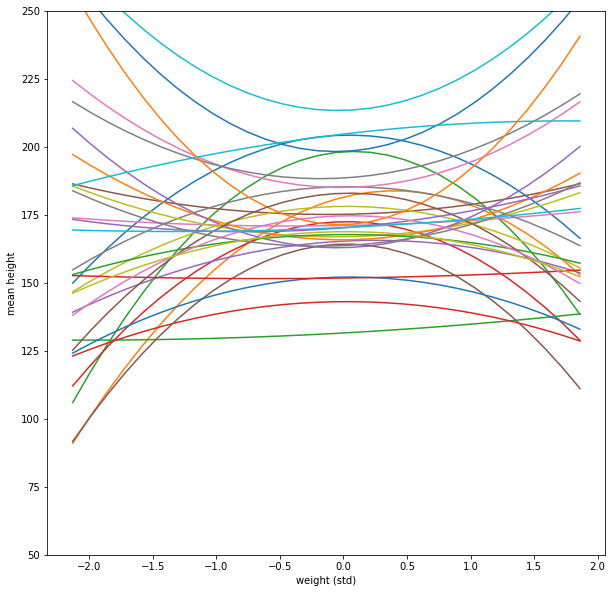

In [105]:
__, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel="weight (std)", ylabel="mean height", ylim=(50,250))
for idx in range(len(prior_checks["height"])):
    plt.plot(weight_seq, 
            prior_checks["a"][idx] +
            prior_checks["b1"][idx] * weight_seq +
            prior_checks["b2"][idx] * weight_seq ** 2,
            "-")